「強化学習（DQN）チュートリアル   」
======

【原題】Reinforcement Learning (DQN) Tutorial

【元URL】https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

【原著】[Adam Paszke](https://github.com/apaszke)

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年12月13日

【チュトーリアル概要】

本チュートリアルでは、[OpenAI Gym ](https://gym.opznai.com/)のCartPole-v0タスクをタスク対象に、深層強化学習アルゴリズムの「Deep Q Learning (DQN)」をPyTorchを用いて実装する方法を解説します。

---

### タスクについて



▼カートポールの図

![](https://pytorch.org/tutorials/_images/cartpole.gif)

エージェント（Agent）は、カート(土台の車)に乗っているポールを、できるかぎり直立した状態を維持することを目指し、行動を選択します。

行動には、カートを「左に動かす」または「右に動かす」のいずれかを選択する必要があります。

このタスク（CartPole-v0）に対する、公式なリーダーボードと、各提出結果で利用されたアルゴリズムの一覧を、[OpenAI Gymのサイト上のページ ](https://gym.openai.com/envs/CartPole-v0)から確認することができます。

**エージェント** （agent）が、 **環境** （environment）の現在の**状態**（state）を観察して、行動を選択します。

すると環境は、新しい状態へと**遷移**し（次の時間stepに進み）、そのstepでの行動結果による**報酬**（reward）を返します。



このタスク（CartPole-v0）では、タイムステップが一単位増えるごとに（＝時間が経過するごとに）報酬が+1されます。

一方で、ポールが傾きすぎたり、カートが画面中心から2.4ユニット以上離れた場合には、失敗として1エピソードの環境は終了します。

つまり、エージェントがより上手い行動選択をすると、タスクはより長い期間実行され、より大きな報酬和が得られる、ということです。

カートポールのタスクでは、エージェントへの入力値は、環境の状態を表す4つの実数値となっています（位置や速度など）。

ですが、ニューラルネットワークは使用すれば、位置や速度の実数値が入力されなくても、カートポールの画面を見るだけでタスクを解くことができます（すなわち、人間が実際に操作する場合と同様の条件です）。

そこで、本チュートリアルでは「カートを中心とした画面の画像パッチ」を入力値として使用します。

<br>

（※日本語訳注：

パッチというのは、画像の一部という意味です。

実際に描画されるスクリーン全体ではなく、DQNに必要な画像範囲のみを切り取り、ディープラーニングで扱う画像サイズを小さくします。）


なお厳密には、現在の画面パッチと前のタイムステップの画面パッチの差を、状態としてエージェントに提示、入力することにします。

こうすることによって、エージェントは、1枚の画像からカートやポールの移動速度を考慮できるようになります。


なお入力が異なるため、本チュートリアルの結果は、CartPole-v0公式リーダーボードの結果とは直接比較できません。

また本チュートリアルで解くタスクは、公式タスクよりも難しいものとなっています。

加えて、残念なことに、全てのフレームをレンダリングしなければならないため、（公式のタスク条件の場合と比較して）訓練にも、より多くの時間がかかります。





（日本語版追記：
CartPole-v0の仕様はこちらとなります：https://github.com/openai/gym/wiki/CartPole-v0 )

**パッケージ**

まずは必要なパッケージをインポートします。

環境として、[Open AIのgym](https://gym.openai.com/docs) が必要となります。

`pip install gym` でインストールしてください。

また、PyTorchの以下の機能を利用します。

-   ニューラルネットワーク (``torch.nn``)
-   最適化 (``torch.optim``)
-   自動微分 (``torch.autograd``)
-   画像系タスク用のユーティリティのパッケージ ([`torchvision -a separate
    package`](https://github.com/pytorch/vision))]

---


日本語版では、本チュートリアルのノートブックをGoogle Colab上で実行し、OpenAY Gymの画像表示が動作するように、必要なパッケージを以下のように追加します。

In [1]:
# 日本語版では、Google Colab上でOpenAY Gymを動作させるために必要なパッケージをインストールしています
!apt update
!apt install xvfb
!pip install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [43.2 kB]
Hit:12 http://ppa.launchp

In [2]:
# 2020/12/20時点のGoogle Colab上でカートポールの画面を可視化するためには、
# 仮想ディスプレイの設定が必要だったため、日本語版では追加しています。
# （参考：https://github.com/openai/gym/issues/1898#issuecomment-729961279）

from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

日本語版用の追加、以上

---

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# matplotlibの設定
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

リプレイメモリ（Replay Memory） 
--------------

DQNを訓練するために、リプレイメモリのクラスを定義し、利用します。

エージェントが観測した状態の遷移を、このリプレイメモリに記憶させることで、状態のデータを後で再利用できるようにします。

このリプレイメモリから状態のデータをランダムにサンプリングすることで、バッチを構成する遷移のデータは時間に対して相関がないようになります。

バッチ内のデータが無相関化されることにより、DQNの訓練は大幅に安定し、同時に改善されることが示されています。



これを実現するためには、2つのクラスが必要です。

-   `Transition`<br>
     環境における一つ一つの状態遷移を表す名前付きタプル（`namedtuple`)です。<br>
    実際に表現している内容は、(`state`:状態, `action`:行動)というペアから、 (`next_state`:次の状態, `reward`:報酬)形式の結果へのマッピングです。

-   `ReplayMemory`<br>
    サイズに制限のあるバッファ（サイクルするバッファ）で、直近に観測された状態遷移を保持します。<br>
    また、訓練時に、遷移のランダムなバッチを取得する関数`sample() `が実装されています。

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """状態遷移の保存"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

それでは次に、モデルを定義しましょう。

ですがその前に、DQNアルゴリズムについて簡単に復習しておきましょう。

DQN アルゴリズム 
----------------------------

本チュートリアルにおける環境は決定論的なものとなっています。

このことから、本チュートリアルで提示される数式は単純化のために、全て決定論的なものを記載しています。

なお、強化学習に関する一般的な記述では、環境が確率的遷移する場合の期待値について記載しています。



ここでの目的は、割引累積報酬 $R_{t_{0}} = \sum_{t = t_{0}}^{\infty}\gamma^{t - t_{0}}r_{t}$を最大化するように方策関数を訓練することです。

<br> 

上記の累積報酬の式における$R_{t_{0}}$は**利得**（return）とも呼ばれます。

$\gamma$は割引率（時間割引）を示しており、0~1の定数である必要があります。

$\gamma$が0~1であることで、報酬の累積が収束することが保証されます。

また、この割引率$\gamma$の存在により、エージェントは、不確実な未来の報酬よりも、確実性が高いより直近の報酬の方を重要視して捉えるように設定されています。



（日本語訳注：$t$について補足します。$t$は、あるタイムステップを意味します。<br>
したがって、$R_{t_{0}}$は、タイムステップ$t$が$t_{0}$から始まって${\infty}$まで経過した場合の報酬$r_{t}$の総和であることがわかります。

また、「報酬」は、ある状態に対する行動の結果得られるものです。<br>
これに対し「利得」は、時系列や期間を考慮して報酬を評価したものです。<br>
ここでは、ある期間における割引された報酬の累積が利得になっています。）

Q-learningの基本的な考え方は、とある状態で、とある行動を取った時の利得を計算する関数（$Q^{*}:State \times Action \rightarrow \mathbb{R}$）が与えられていれば、利得を最大化する方策（≒エージェントが取るべき行動作戦）は簡単に定義できるはずだ、というものです。

この方策の関数は、以下の式で表現されます。

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

（日本語訳注：$\pi$は方策、$s$は状態、$a$は行動を意味しています）

とはいえ、実際には世の中のこと、環境の持つをすべてを知っているわけではないため、真の$Q^{*}$関数を事前に記載することはできません。

しかし、ニューラルネットワークは普遍的な関数近似器であるため（日本語訳注：ニューラルネットワークにはどんな関数でも近似できる性質があるため）、ニューラルネットワークを利用し、$Q^{*}$に近づくように訓練させることで、近似的な$Q^{*}$を利用することが可能となります。

訓練時の方策の更新ルールとしてここでは、ある方策に対するすべての $Q$関数は、ベルマン方程式に従うという事実を利用します。

以下に、ベルマン方程式を掲載します。

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}



（日本語訳注：
$s'$は、現在の状態$s$からの遷移先の状態（次の時間stepの$s$）を示しています。

したがって上記の式は、「現在のタイムステップにおける利得の期待値$Q^{\pi}(s, a)$は、「実際に行動して次のタイムステップに遷移した場合における利得の期待値 $r+\gamma Q^{\pi}(s', \pi(s'))\$ と等しい 」ということを意味しています。）

上記の等式の両辺の差は、TD誤差（TD=Temporal Difference） $\delta$と呼ばれ、以下の式で表現されます。


\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}




（日本語訳注：両辺の差分、TD誤差を最小化する理由は、「現在のタイムステップにおける利得の期待値」と、「実際に行動して次のタイムステップに遷移した場合の利得の期待値」の誤差が0になれば、次の時刻の報酬を完全に把握して行動選択できる≒Q関数がきちんと構築された、を意味するためです。）

このTD誤差を最小化するために、[フーバー損失](https://en.wikipedia.org/wiki/Huber_loss)を使用します。

以下に、フーバー損失の数式を掲載します。



\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}


フーバー損失は、誤差が小さいときには平均二乗誤差のように働きますが、誤差が大きいときには平均絶対値誤差のような働きをします。

フーバー損失により、 $Q$ の推定値にノイズが非常に多い場合、外れ値に対してよりロバストになります。

リプレイメモリ（`ReplayMemory`）からサンプリングした遷移のバッチ $B$ に対して、この損失計算を適用します。



### Q-network 

今回構築するモデルは、現在の画面パッチと前の画面パッチの差を入力とする畳み込みニューラルネットワークです。

このモデルの出力値は2つの値となり、それぞれ、$Q(s,left)$と $Q(s,right)$の結果に対応しています。

（なお、$s$はネットワークへの入力値である状態を示します。）


実際には、ネットワークは、現在の入力（＝状態）において行動を取ることで得られる**利得の期待値**を予測しようとしています。


（日本語訳注：上記は要するに、$s$という状態で、「左に動かす」という選択をした場合の利得と「右に動かす」という選択をした場合の利得が出力される、ということです。）

In [5]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # 線形レイヤへの入力次元の数は、conv2dレイヤーの出力のサイズに依存（元を辿れば入力画像のサイズに依存）します。
        # そこで、conv2dレイヤーの出力サイズを計算しています。
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    #  最適化の最中に、以下のいずれかの操作で呼び出されます。
    # 1.次の行動を決定するための要素
    # 2.バッチの処理
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### 入力値の抽出

以下のコードは、環境からレンダリングされた画像を抽出して処理するためのユーティリティ（補助関数）です。

画像変換の処理を簡単に構築することができる`torchvision `パッケージを使用しています。

以下のセルを実行すると、パッチを抽出した例が表示されます。

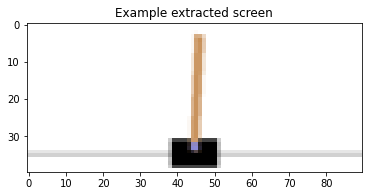

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
  world_width = env.x_threshold * 2
  scale = screen_width / world_width
  return int(env.state[0] * scale + screen_width / 2.0) # カートの真ん中

def get_screen():
  # gymｄ使用されるスクリーンのサイズは400x600x3ですが、
  # 実際のスクリーンがそれよりも大きい場合もあります。（ 例えば800x1200x3など）
  # ここでは、スクリーンの次元の順序を、Pytorch標準の次元の順序(CHW)に並び替えます
  screen = env.render(mode='rgb_array').transpose((2, 0, 1))
  # カートはスクリーンの下半分にあるので、上下をトリミングします
  _, screen_height, screen_width = screen.shape
  screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
  view_width = int(screen_width * 0.6)
  cart_location = get_cart_location(screen_width)
  if cart_location < view_width // 2:
      slice_range = slice(view_width)
  elif cart_location > (screen_width - view_width // 2):
      slice_range = slice(-view_width, None)
  else:
      slice_range = slice(cart_location - view_width // 2,
                          cart_location + view_width // 2)
  # 縁をトリミングし、カートの中央に四角い画像がくるようにします
  screen = screen[:, :, slice_range]
  # floatに変換し、再拡大して、Pytorchテンソルに変換します
  # (この操作では変数のコピーは不要です。)
  screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
  screen = torch.from_numpy(screen)
  # リサイズをして、バッチ数の次元を追加します。(BCHW)という形になります。
  return resize(screen).unsqueeze(0).to(device)


# 1回実行して、描画
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

訓練（Training）
------------

### ハイパーパラメータとユーティリティ


以下で実装するセルでは、モデルとそのオプティマイザのインスタンスを作成し、さらに、いくつかのユーティリティ関数（補助関数）を定義しています。

-   `select_action`<br>
    ε-greedy法に従って行動を選択する関数です。<br>
    エージェントは、今回作成したニューラルネットワークのモデルを使って行動を選択することもあれば、一様分布からのサンプリング結果をもとにランダムに行動を選択することもあります。<br>
    ランダムに行動を選択する確率は`EPS_START `から始まり、`EPS_END `に向かって指数関数的に減衰していきます。<br>
    `EPS_DECAY`は減衰の速度を制御します。
-   `plot_durations`<br>
    エピソードの持続時間を、過去100エピソードの平均値（公式評価で使用される指標）と一緒にプロットする補助関数です。
    プロットは、メインの訓練ループを含むセルの下に表示され、各エピソードの後に更新されます。<br>
    （日本語訳注：1エピソードとは、環境が開始されてから終了するまでの期間です。
    <br>ここではカートが動き始めてからポールが、一定角度以上倒れる、もしくはカートが横に移動しすぎるまでの期間です。）


In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05 
EPS_DECAY = 200  
TARGET_UPDATE = 10

# カート・ポールの画面サイズを取得し、gymから返される形状に基づき正しくレイヤーを初期化できるようにします
# ここで取得している画面のサイズは、3x40x90程度となっています。
# この3x40x90というサイズは、get_screen() 内でトリミングや縮小が施されたたrender buffer（描画されるカート・ポールの画面）のサイズです
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Open AI Gymのアクションスペースから、選択できる行動の数を取得します
# （日本語訳注：ここでは、「右に動かす」と「左に動かす」の２つの行動が選択できるので、n_actionsの値は2となります）
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
        # t.max(1) は、テンソルの行方向の最大値に対応する列を返します。
        # max(1)[1]は、最大値に対応する列のインデックスを示しています。
        # つまり、このコードは報酬の期待値が最大となる行動を選択していることを意味します。
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100エピソードの平均を取り、プロットします。
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # プロットを更新するために一時停止します
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### 訓練ループ 

最後に、モデルを訓練するためのコードです。

ここでは、最適化のステップを実行する`optimize_model `関数を定義しています。



この関数ではまずバッチをサンプリングします。

次に、すべてのテンソルを1つに連結します。

そして$Q(s_{t},a_{t})$と$V(s_{t + 1}) = \text{max}_{a}Q(s_{t + 1},a)$を算出して、これらを結合した結果を損失とします。

（日本語訳注：$V(s_{t + 1})$は、状態$s_{t + 1}$の時に報酬が最大化される行動を取った時の利得です。）

定義から、$s$が最終状態の場合は$V(s) = 0$となります。



また、$V(s_{t + 1})$を算出するために、別途ターゲット・ネットワークを使用し、安定性を高めています。

ターゲット・ネットワークの重みは基本的には更新されませんが、時々、方策用ネットワークの重みで更新されます。

通常、更新するタイミングはステップ数を使って設定しますが、本チュートリアルでは簡単のためにエピソードを使用します。

（日本語訳注：本チュートリアルでは、10エピソードごとにターゲット・ネットワークの重みを更新しています）

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # バッチを転置します (詳細はhttps://stackoverflow.com/a/19343/3343043 を参照してください)
    # この処理では、Transitionsがバッチ配列になっているオブジェクトを、
    # バッチ配列がTransitionになっているオブジェクトに変換します
    batch = Transition(*zip(*transitions))

    # 最終状態「以外」を取り出すmaskを適用した後、バッチの要素を連結します。
    # (最終状態になるのは、シミュレーションが終了した後です)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a)を算出します。
    # 具体的には、作成したモデルでQ(s_t)を算出し、そこから各行動を示すカラムに対応する値を取得します
    # 値を取得するために使ったカラムは、バッチ内の各状態に対して、policy_netに従って取られた行動となっています
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 全ての遷移先の状態について、V(s_{t+1})を計算します
    # non_final_next_statesにおける行動の結果もたらされる利得の期待値は、「更新前の」target_netに基づいて計算されます
    # target_netのmax(1)[0]では、報酬の最大値を選択しています
    # この報酬は、最終状態の場合は0となりますが、それ以外の場合には、遷移先の状態における利得の期待値となります
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 遷移先の状態におけるQの期待値を計算します
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # フーバー損失を計算します。
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # モデルを最適化します。
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

以下に、メインの訓練ループのコードを実装します。

まず環境をリセットし、状態（`state`）テンソルを初期化します。

次に、行動を選択し、実際にその行動を取ります。

そして、状態が遷移した後の次の画面と報酬（これは常に1です）を観察し、モデルを一度最適化更新します。

これを繰り返し、エピソードが終了したら（作成したモデルがカート・ポールを失敗もしくは200 step立ち続けたら）、再び上記のループを最初から行います。




なお、以下に掲載しているコードでは、`num_episodes`が小さめに設定されています。

本ノートブックをダウンロードして実際に実行する際には、より多くのエピソード（例えば、300以上）実行し、訓練時間の長さを改善する必要があります。

In [9]:
num_episodes = 100  # 元々50でしたが、日本語版は変更（3分ほど時間がかかります）
TARGET_UPDATE = 1  # 元々10でしたが、日本語版は変更
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)  # 元々学習率はdefaultの1e-2、日本語版は変更


for i_episode in range(num_episodes):
    # 環境と状態を初期化します
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # アクションを選択して実行します
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 新しい状態を観察します
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # 遷移をメモリに保存します
        memory.push(state, action, next_state, reward)

        # 次の状態に遷移
        state = next_state

        # 最適化のステップを(ターゲットネットワーク上で)実行します
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            print("EPISODE:{} | TotalStep:{}".format(i_episode,t))  # 日本語版追記
            # plot_durations()  # 日本語版コメントアウト
            break

    # DQNの重みとバイアスをすべてコピーし、ターゲット・ネットワークを更新します
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

EPISODE:0 | TotalStep:14
EPISODE:1 | TotalStep:13
EPISODE:2 | TotalStep:15
EPISODE:3 | TotalStep:20
EPISODE:4 | TotalStep:12
EPISODE:5 | TotalStep:13
EPISODE:6 | TotalStep:24
EPISODE:7 | TotalStep:35
EPISODE:8 | TotalStep:29
EPISODE:9 | TotalStep:27
EPISODE:10 | TotalStep:10
EPISODE:11 | TotalStep:11
EPISODE:12 | TotalStep:10
EPISODE:13 | TotalStep:26
EPISODE:14 | TotalStep:17
EPISODE:15 | TotalStep:12
EPISODE:16 | TotalStep:24
EPISODE:17 | TotalStep:22
EPISODE:18 | TotalStep:24
EPISODE:19 | TotalStep:30
EPISODE:20 | TotalStep:15
EPISODE:21 | TotalStep:55
EPISODE:22 | TotalStep:15
EPISODE:23 | TotalStep:122
EPISODE:24 | TotalStep:17
EPISODE:25 | TotalStep:128
EPISODE:26 | TotalStep:86
EPISODE:27 | TotalStep:59
EPISODE:28 | TotalStep:47
EPISODE:29 | TotalStep:13
EPISODE:30 | TotalStep:18
EPISODE:31 | TotalStep:24
EPISODE:32 | TotalStep:58
EPISODE:33 | TotalStep:130
EPISODE:34 | TotalStep:46
EPISODE:35 | TotalStep:27
EPISODE:36 | TotalStep:41
EPISODE:37 | TotalStep:41
EPISODE:38 | TotalS

---

日本語版追加：訓練後の動作を動画で確認


In [10]:
# 参考記事：Qiita「【強化学習】OpenAI Gym を Google Colab上で描画する方法 (2020.6版)」
# https://qiita.com/ymd_h/items/c393797deb72e1779269


In [11]:
# 日本語版追加：訓練後の様子
import gym
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from matplotlib import animation

# 環境と状態を初期化します
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen

# 動画化用
d = Display()
d.start()
img = []
img.append(env.render('rgb_array'))

for t in count():
    # アクションを選択して実行します
    action = select_action(state)
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    # 新しい状態を観察します
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    # 次の状態に遷移
    state = next_state

    # 動画化に毎step描画を追加
    display.clear_output(wait=True)
    img.append(env.render('rgb_array'))

    print(t)
    
    if done:
        break

# 実行によっては、短時間で失敗するので、このセルを何回か実行してみる。  
# 今回のモデルはチュートリルの簡易モデルなので、あまり長時間立てる制御は難しい・・・ 

69


In [12]:
# 動画を表示

dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))
plt.close()


日本語版追加：

以上

---

最終的なデータフローの全体像を表した図を以下に掲載します。

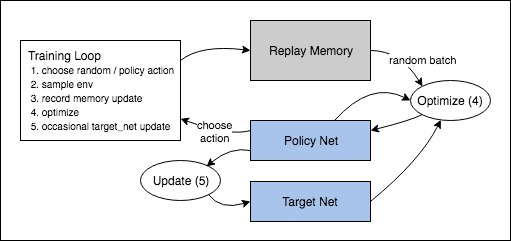

- 行動の選択はランダムになされるか、もしくは方策（policy）に基づいて選択されます。<br>
（1. choose random / policy action）

- そして、Open AI Gymの環境から、次のステップのサンプルを取得します。<br>
（2. sample env）

- 行動の結果はリプレイメモリ（Replay Memory)に記録されます。<br>
（3. record memory update）

- そしてループするたびに最適化（Optimize）が実行されます。<br>
（4. optimize）。最適化（Optimize）では、新しい方策（Policy Net）の訓練を行うために、リプレイメモリからランダムにバッチを選択します。

- Qの期待値を算出するために、更新前のtarget_netも最適化（Optimize）処理内で利用されます。そしてこのtarget_netは最新の値を反映するたびに、時折更新されます。<br>
（5. occasional target_net update）